# Angle Alignment - Another equation proposal

In this notebook we present slightly different optimization equation than the one we decided to finally use.

\begin{equation}
\label{eq:phase1}
\operatorname*{min}_{q_L, q_R \in S^3} \frac{1}{n} \sum_{i=1} d_q(q_i, q_L \cdot \hat{q_i} \cdot q_R)
\end{equation}

- $d_q$ is the distance between two quaternions

\begin{equation}
\label{eq:eq2}
d(q_1,q_2)=2arccos(|<q_1,q_2>|)
\end{equation}

- $q_i \in S^3$ is the quaternion of a true rotation angles

- $\hat{q_i} \in S^3$ is the rotation of the estimatied rotation angles

- $q_L \in S^3$ left-isoclinic rotation represented by left-multiplication of the estimated quaternion

- $q_R \in S^3$ right-isoclinic rotation represented by right-multiplication of the estimated quaternion


In this case, the optimization is concentration on minimizing the function loss by changing the left- and right- isoclinic rotations represented as a quaternion. This method as well as the one chosen as the final one do the same thing. Therefore, just a different representation is introduced here (working with two quaternions instead of working with one 4D rotation matrix). 

In [1]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython import display as IPyDisplay
import ipyvolume as ipv
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow_graphics.geometry.transformation import quaternion
import seaborn as sns; sns.set(style="white", color_codes=True)
import random
from tensorflow_graphics.math import vector
from itertools import product
import time
from tensorflow_graphics.util import safe_ops, asserts, shape
import math
from scipy.spatial.transform import Rotation as R

In [1]:
import sys
sys.path.append("..")
from oml.angles import quaternion2euler, euler2quaternion, d_q
from oml.alignment import angles_transpose

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1816809573819230230
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12548246620952433758
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12134695565463289576
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3094937600
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15450478778985634396
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Read data for the optimization

#### Prediction angles from previous phase that we want to align with true angles

In [7]:
# read predicted quaternions and convert them to euler angles
quaternion_predicted = np.load("../data/predicted_quaternions2.npy")
angles_predicted = quaternion2euler(quaternion_predicted)

# read true euler angles
angles_true = np.load("../data/angles_true.npy")

In [56]:
#from cryoem.conversions import euler2quaternion, d_q, quaternion2euler
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow_graphics.geometry.transformation import quaternion
from time import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)
import random
from tensorflow_graphics.math import vector
from itertools import product
#from cryoem.rotation_matrices import euler2matrix, d_r
import time
from IPython import display as IPyDisplay
from scipy.spatial.transform import Rotation as R


def update_quaternion(q_L, q_R, q_predicted):
    #q_R = euler2quaternion(a_R)
    # quaternion multiplication is associative
    q_predicted_rotated = quaternion.multiply(quaternion.multiply(q_L, q_predicted), q_R)

    return q_predicted_rotated

def loss_alignment(q_L, q_R, q_predicted, q_true):
    #q_R = euler2quaternion(a_R)
    q_predicted_rotated = quaternion.multiply(quaternion.multiply(q_L, q_predicted), q_R)

    return tf.reduce_mean(d_q(q_true, q_predicted_rotated))


def gradient_alignment(q_L, q_R, q_predicted, q_true):
    with tf.GradientTape() as tape:
        loss_value = loss_alignment(q_L, q_R, q_predicted, q_true)
        gradient = tape.gradient(loss_value, q_L+q_R)
        
    return loss_value, gradient


def training_angle_alignment(steps, batch_size, learning_rate, angles_true, angles_predicted):
    
    collect_data = []

    optimizer = Adam(learning_rate=learning_rate)

    time_start = time.time()

    report = ""

    losses = np.empty(steps)
    angles_predicted = tf.convert_to_tensor(angles_predicted)

    q_R = [tf.Variable(quaternion.normalized_random_uniform([1]))]
    q_L = [tf.Variable(quaternion.normalized_random_uniform([1]))]
    
    q_predicted = tf.cast(euler2quaternion(angles_predicted), dtype=tf.float32)
    q_true = tf.cast(euler2quaternion(angles_true), dtype=tf.float32)

    for step in range(1, steps+1):

        # Sample some pairs.
        idx = list(np.random.choice(range(len(angles_predicted)), size=batch_size))

        # Compute distances between projections
        qt = [q_true[i]      for i in idx]
        qp = [q_predicted[i] for i in idx]

        # Optimize by gradient descent.
        losses[step-1], gradients = gradient_alignment(q_L, q_R, qp, qt)
        optimizer.apply_gradients(zip(gradients, q_L+q_R))

        update_lr = 300
        if step>update_lr and step%update_lr==0 and losses[step-1]-losses[step-1-update_lr+100] < 0.1:
            learning_rate *= 0.1

        # Visualize progress periodically
        if step % 10 == 0:
            qu = update_quaternion(q_L, q_R, q_predicted)

            collect_data.append(qu.numpy())

            plt.close();
            sns.set(style="white", color_codes=True)
            sns.set(style="whitegrid")

            fig, axs = plt.subplots(1, 3, figsize=(24,7))

            # Distance count subplot (batches)
            qpr = update_quaternion(q_L, q_R, qp)
            d1 = d_q(qpr, qt)
            axs[0].set_xlim(0, np.pi)
            axs[0].set_title(f"BATCHES (size={len(qp)}): [{step}/{steps}] Distances between true and predicted angles \nMEAN={np.mean(d1):.2e} STD={np.std(d1):.2e}")
            s = sns.distplot(d1, kde=False, bins=100, ax=axs[0], axlabel="Distance [rad]", color="r")
            max_count = int(max([h.get_height() for h in s.patches]))
            axs[0].plot([np.mean(d1)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

            # Optimization loss subplot
            axs[1].plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
            axs[1].set_xlabel('time [s]')
            axs[1].set_ylabel('loss');
            axs[1].set_title(f"Angle alignment optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")

            # Distance count subplot (full)
            q_predicted_rot = update_quaternion(q_L, q_R, q_predicted)
            d2 = d_q(q_predicted_rot, q_true)
            axs[2].set_xlim(0, np.pi)
            axs[2].set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
            s = sns.distplot(d2, kde=False, bins=100, ax=axs[2], axlabel="Distance [rad]", color="r")
            max_count = int(max([h.get_height() for h in s.patches]))
            axs[2].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)


            IPyDisplay.clear_output(wait=True)
            IPyDisplay.display(plt.gcf())
            plt.close();
            time.sleep(1.0)


        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time.time() - time_start
            report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {np.mean(losses[step-steps//10:step-1]):.2e}\n'

        if step >= 101 and np.mean(losses[step-101:step-1]) < 1e-3:
            break;

    print(report)
    return q_L, q_R, losses, np.array(collect_data)

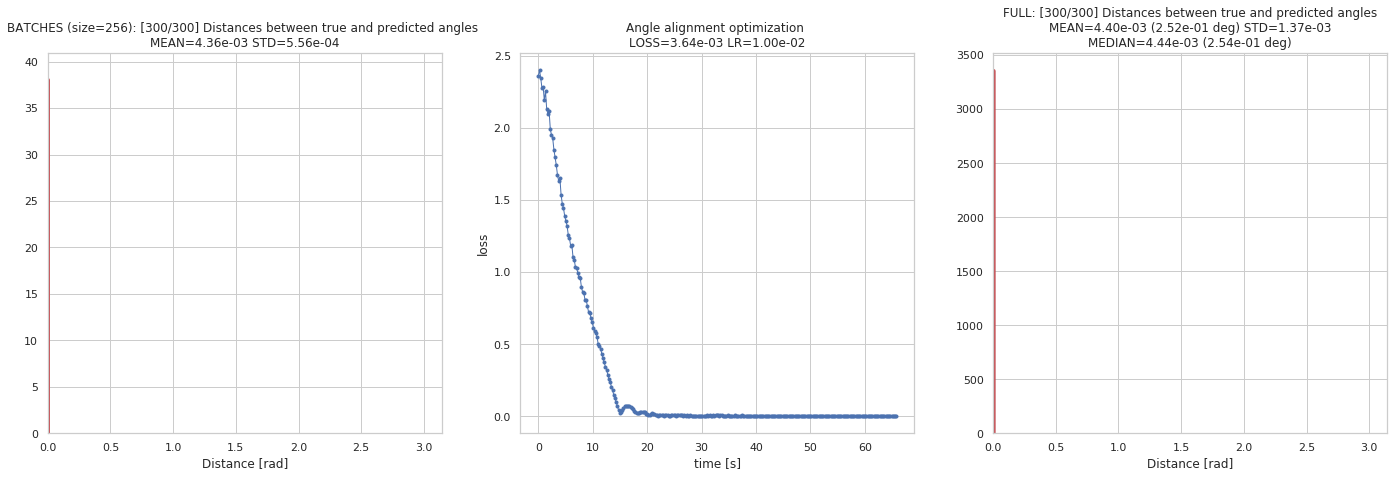

step 30/300 (7s): loss = 1.79e+00
step 60/300 (13s): loss = 6.82e-01
step 90/300 (20s): loss = 7.09e-02
step 120/300 (27s): loss = 9.66e-03
step 150/300 (34s): loss = 4.68e-03
step 180/300 (41s): loss = 5.20e-03
step 210/300 (47s): loss = 4.31e-03
step 240/300 (54s): loss = 4.01e-03
step 270/300 (61s): loss = 3.83e-03
step 300/300 (67s): loss = 3.74e-03



In [57]:
q_L, q_R, loss, collect_data  = training_angle_alignment(steps=300, 
                                                 batch_size=256, 
                                                 learning_rate=0.01, 
                                                 angles_true=angles_true, 
                                                 angles_predicted=angles_predicted)

In [59]:
q_L[0].numpy()

array([[0.03975643, 0.1025083 , 0.5115183 , 0.8035508 ]], dtype=float32)

In [60]:
q_R[0].numpy()

array([[ 0.5873662 , -0.35293624, -0.96615905,  0.24834652]],
      dtype=float32)

#### Conclusion:
We can see that method manages to converge. However, with the current implementation, we would be dealing with optimization of a 8-dimensional vector (4-dimensional vector for each quaternion) instead of 6-dimensional one that we have in case of working with a 4D rotation matrix. Of course, this can be modified to use a 6-dimensional vector (3 angles that will be converted to corresponding 4-dim quaternion).